# Automated segmentation and analysis of mycobacteria smegmatis AFM images. 
### By Keegan Flanagan and Hasti Delfi

In this project, we study AFM images of Mycobacterium smegmatis using an automated pipeline which segments, skeletonizes, and collects metadata for individual cells. 

# 1. Introduction and motivation

Atomic force microscopy (AFM) is a relatively new form of microscopy that is able to directly measure the physical properties of a microscopic object by mechanically scanning the object using a fine-tipped cantilever. AFM has recently begun to be applied to the study of microscopic organisms such as bacteria with exciting results. For example, a study done in 2017 by Eskandarian et al. was able to use AFM to identify a series of wave troughs that predict the location of cleavage sites in future generations of mycobacterium smegmatis. 

Originally, analyzing AFM images required cells to be manually segmented and their skeletons had to be drawn by hand. This method may be suitable for smaller datasets, but it is time consuming and completely impractical for large scale statistical analysis.  Automating the segmentation, skeletonization, and data collection steps of this process will lead to massive optimizations that will allow for large scale analysis of AFM images. 

# 2. Datasets
The dataset used for this project was graciously given to us by Dr. Eskandarian and consists of a series of AFM images of mycobacterium smegmatis. The example analysis used in this notebook represents a small subset of this dataset. This subset represents an idealized dataset where most images only contain 1-3 cells and images with significant visual artifacts were removed. There are three types of AFM images within our example data. These types correspond to the 1) height, 2) stiffness, and 3) peak force error of the cells.

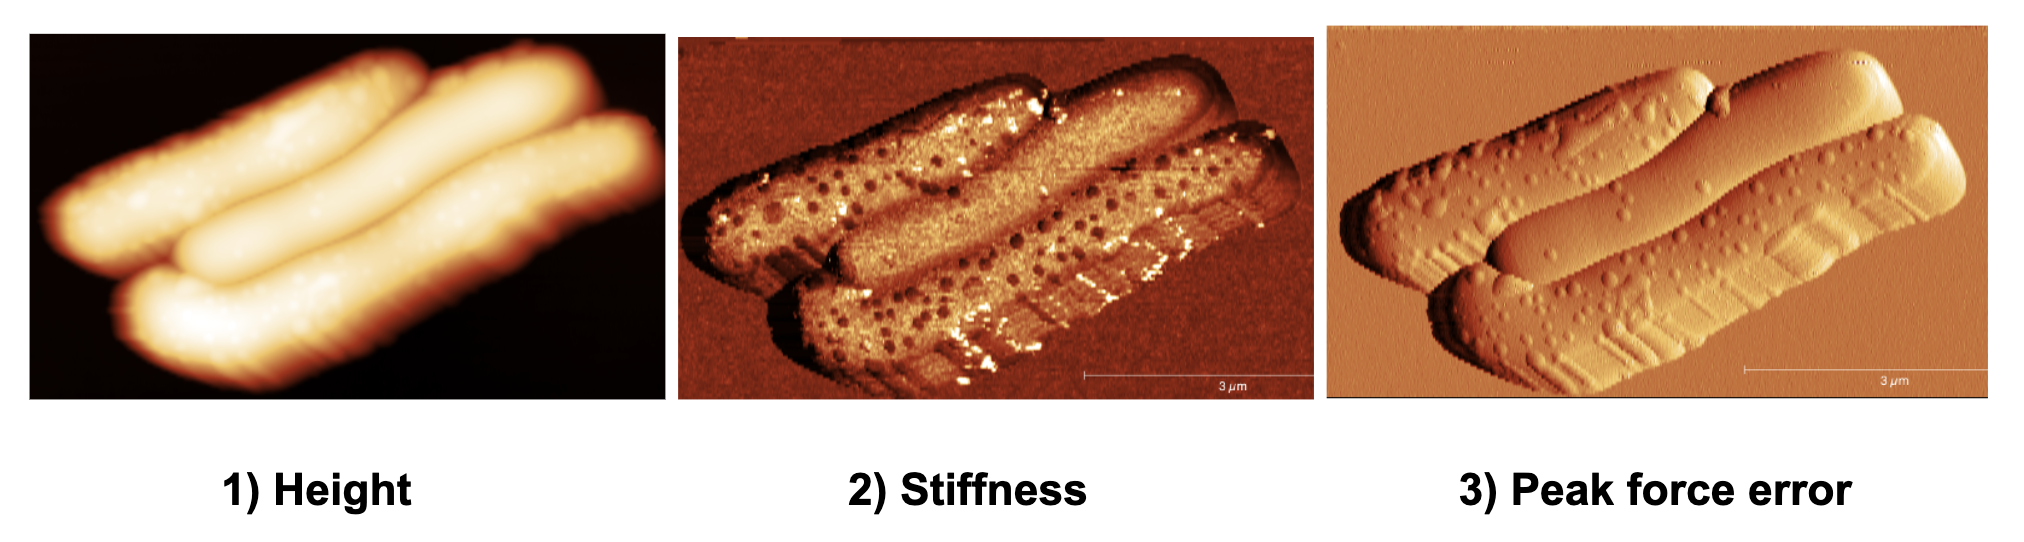

The current example analysis focuses solely on the height images, but we hope that future versions will take into account peak force error and stiffness as well. 

# 3. Analysis
## Setup

The easiest way to ensure that all the necessary packages and required dependencies for this analysis are installed is to run this analysis within a conda environment. If you are unfamiliar with miniconda, you can learn more about it and download it from the following link https://docs.conda.io/en/latest/miniconda.html.

A conda environment with the complete version of Cellpose pre-installed can be created and activated by entering the following commands into the terminal:
```
conda create --name cellpose python=3.8
conda activate cellpose
```
Once the Cellpose conda environment has been activated, additional required packages can be installed via pip using the following commands:

```
pip install jupyterlab
pip install matplotlib
pip install pandas
pip install imutils
pip install imageio
pip install fil_finder
pip install radfil
```
After all of these installations are complete and this notebook is opened within the Cellpose conda environment, the example analysis is ready to be run. 

### Loading in necessary packages and defining paths

In [1]:
import numpy as np
import os, sys
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import pandas as pd
from cellpose import utils, io, models, plot
from scipy.spatial import distance as dist
import re
import tools
from radfil import radfil_class, styles
from astropy import units as u
import imageio.v2 as imageio
import copy
from PIL import Image
from fil_finder import FilFinder2D
from shapely.geometry import Polygon
from skimage.util import invert
from skimage.morphology import skeletonize
from cv2 import imwrite
from tools import prune2
from scipy.interpolate import splprep
from scipy.interpolate import splev
from IPython.core.display import HTML

my_data = "example_data/Height/"
segments_path = "cellpose_output/"
cell_path = "Individual_cells/"

## 3.1 Segmentation
### 3.1.1 Load and sort the initial image files

In [2]:
# Load up a list of input files from our example data.
files = os.listdir(my_data)
for fichier in files[:]:
    if not(fichier.endswith(".png")):
        files.remove(fichier)
        
# Sort files by timepoint.
files.sort(key = tools.natural_keys)      

# Create a list that contains the full path to each of our image files. 
save_names = [segments_path + file for file in files]
file_names = [my_data + file for file in files]

Each image in our example dataset consists of a grayscaled height image wih a scale bar at the side. 

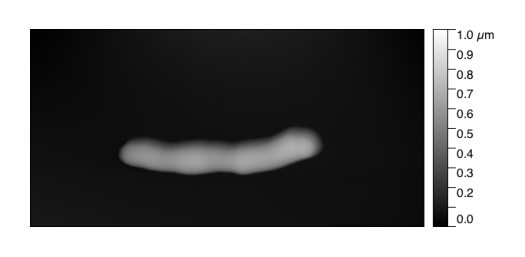

In [3]:
# view an example image.
img = io.imread(file_names[0])
plt.figure(figsize=(2,2))
plt.imshow(img)
plt.axis('off')
plt.show()

### 3.1.2 Run Cellpose

Cellpose is a program which uses a generalist model to perform cell or nucleus segmentation. Cellpose utilizes a deep neural network which was trained on a diverse set of images which comprised over 70,000 individual segmented  objects. This diverse training set allows Cellpose to perform segmentation on a wide range of image types without previous training or parameter adjustment. We are going to use this pre-trained cytoplasm model for our segmentation. 

In [4]:
# Specify that the cytoplasm Cellpose model for the segmentation. 
model = models.Cellpose(gpu=False, model_type='cyto')

# define CHANNELS to run segementation on
# grayscale=0, R=1, G=2, B=3
# channels = [cytoplasm, nucleus]
channels = [0,0]

# Loop over all of our image files and run Cellpose on each of them. 
for filename, savename in zip(file_names, save_names):
    img = io.imread(filename)
    masks, flows, styles, diams = model.eval(img, diameter = 80, channels=channels, flow_threshold = 0.8)

    # save results so you can load in gui
    io.masks_flows_to_seg(img, masks, flows, diams, savename, channels)

    #save results as png
    io.save_to_png(img, masks, flows, savename)

100%|██████████████████████████████████████████████████████████████████████████████| 25.3M/25.3M [00:00<00:00, 27.0MB/s]
100%|██████████████████████████████████████████████████████████████████████████████| 5.23k/5.23k [00:00<00:00, 11.6MB/s]


Below we can see an illustrative example of Cellpose's outputs. Each cell in the original image has an associated outline and mask which cover the perimeter and area of the cell respectively. The image to the far right shows the predicted vector fields for each cell.

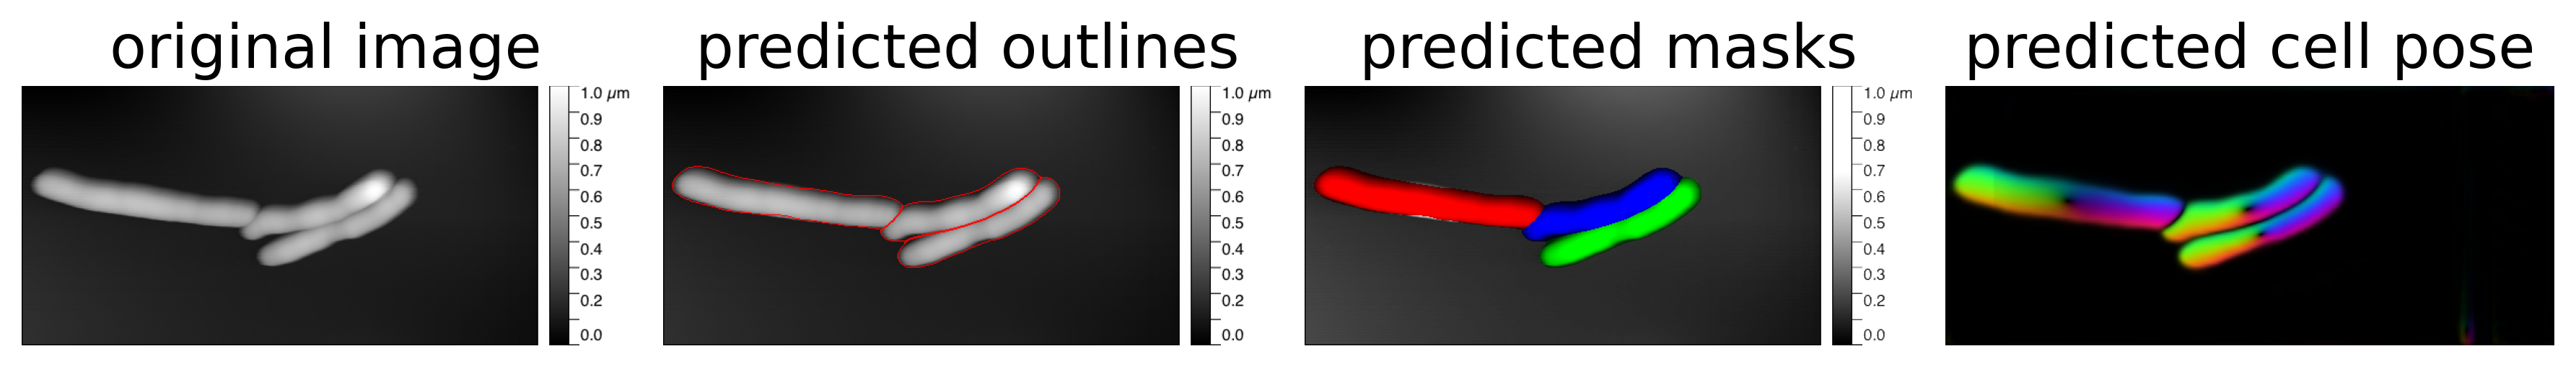

In [5]:
# Display an example of Cellposes output. 
fig = plt.figure(figsize=(12,5))
plot.show_segmentation(fig, img, masks, flows[0], channels=channels)
plt.tight_layout()
plt.show()

The following plot shows the vector flow fields generated by Cellpose. These flow fields are what Cellpose uses to deliminate cells from each other. One can observe that all of the pixels within the individual cells follow a gradient to a single cell centerpoint which is visible as a black dot. This allows Cellpose to map each individual pixel to the center of the cells which is how Cellpose decides if a pixel is inside of a cell. 

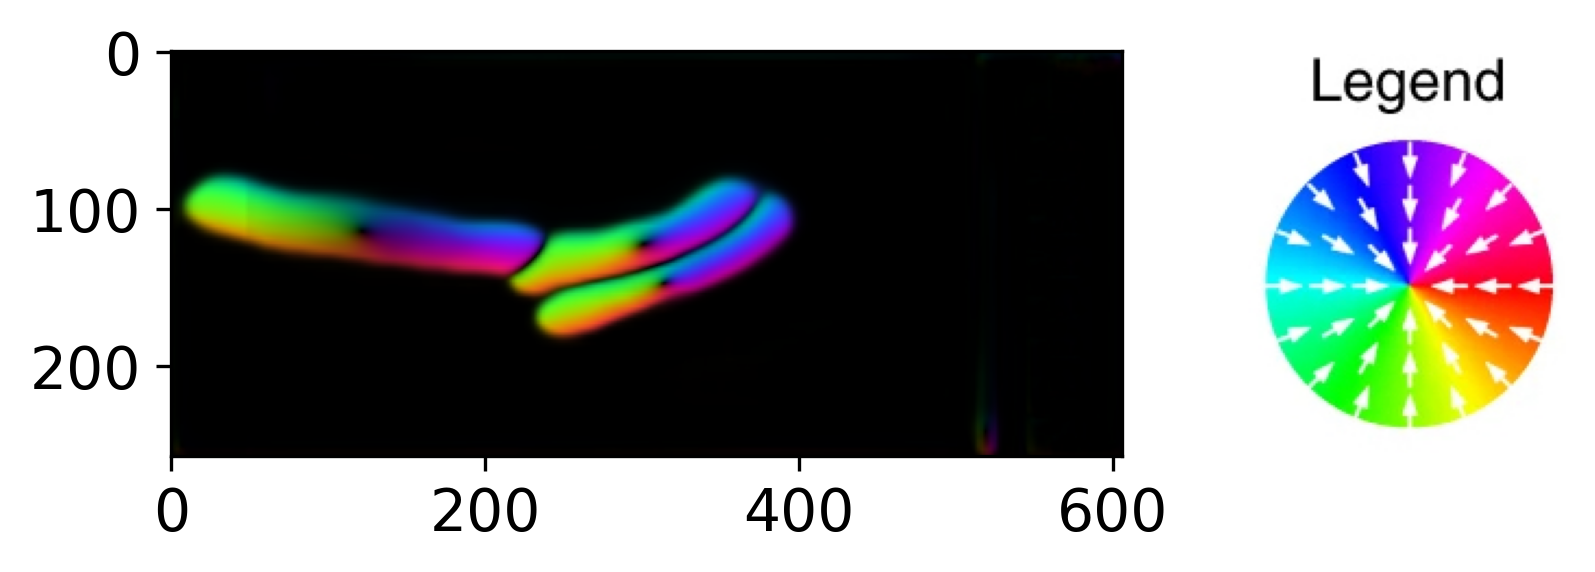

In [6]:
legend = imageio.imread("flow_legend.jpg")
fig, ax = plt.subplots(1,2, gridspec_kw={'width_ratios': [3, 1]})
ax[1].axis("off")
ax[0].imshow(flows[0])
ax[1].imshow(legend)

## 3.2 Collect metadata

After the cells in our images have been properly segmented, we will want to analyze the masks and outlines outputted by Cellpose in order to collect data on several cell parameters over time. The parameters we are interested in includes the perimeter of the cell, the area of the cell, the degree to which a cell touches another cell, the location of the cell, the hight along the cells medial axis or skeleton, and the radial profile. We would also like to analyze how these parameters change over time for each cell, so a simple cell tracking algorithm has been implemented in order to keep track of each cell over time. 

### 3.2.1 Load up segmentation files

The segmentation files generated in the last step can now be loaded back into Jupyter for analysis. Each of the images and associated segmentation files from the example dataset contain a timepoint within their file names. This makes it easy to sort the data from earliest to latest which will be important for cell tracking and for the organization of the metadata. 

In [2]:
# Get the filenames for our segmentation datasets. 
segmented = os.listdir(segments_path)
for fichier in segmented[:]: 
    if not(fichier.endswith(".npy")):
        segmented.remove(fichier)

# Sort the filenames by timepoint. 
segmented.sort(key = tools.natural_keys)

# Create a list that records the timepoints for every image. 
time_list = []
for segment in segmented:
    time_list.append(int(re.findall(r'\d+', segment)[0]))

Before the desired cell parameters are estimated, small cell masks/outlines are removed from the segmentation datasets. This is done because small masks are often the result of Cellpose picking up on small visual artifacts present in the AFM data. This simple size filter removes the vast majority of these artifacts. The original image and the cell outlines are then extracted from each of the original segmentation datasets. These outputs will be sufficient to calculate all of the additional parameters needed for the metadata.

In [3]:
# Initialize lists.
outl_temp = []
height_img_list = []

# Fill lists with img and outline data from each segment
for segment, time in zip(segmented, time_list):
    # Load up the segmentation data. 
    dat = np.load(segments_path + segment, allow_pickle=True).item()
    
    # Remove small masks from the data
    dat["masks"] = utils.fill_holes_and_remove_small_masks(dat["masks"], min_size = 800)
    
    # Populate list with each cell outline.
    outl = utils.outlines_list(dat['masks'])
    outl_temp.append(outl)
    
    # Populate list with each original image.
    image = dat["img"]
    height_img_list.append(image)

The code below shows an illustrative example of a cell with its associated outline. 

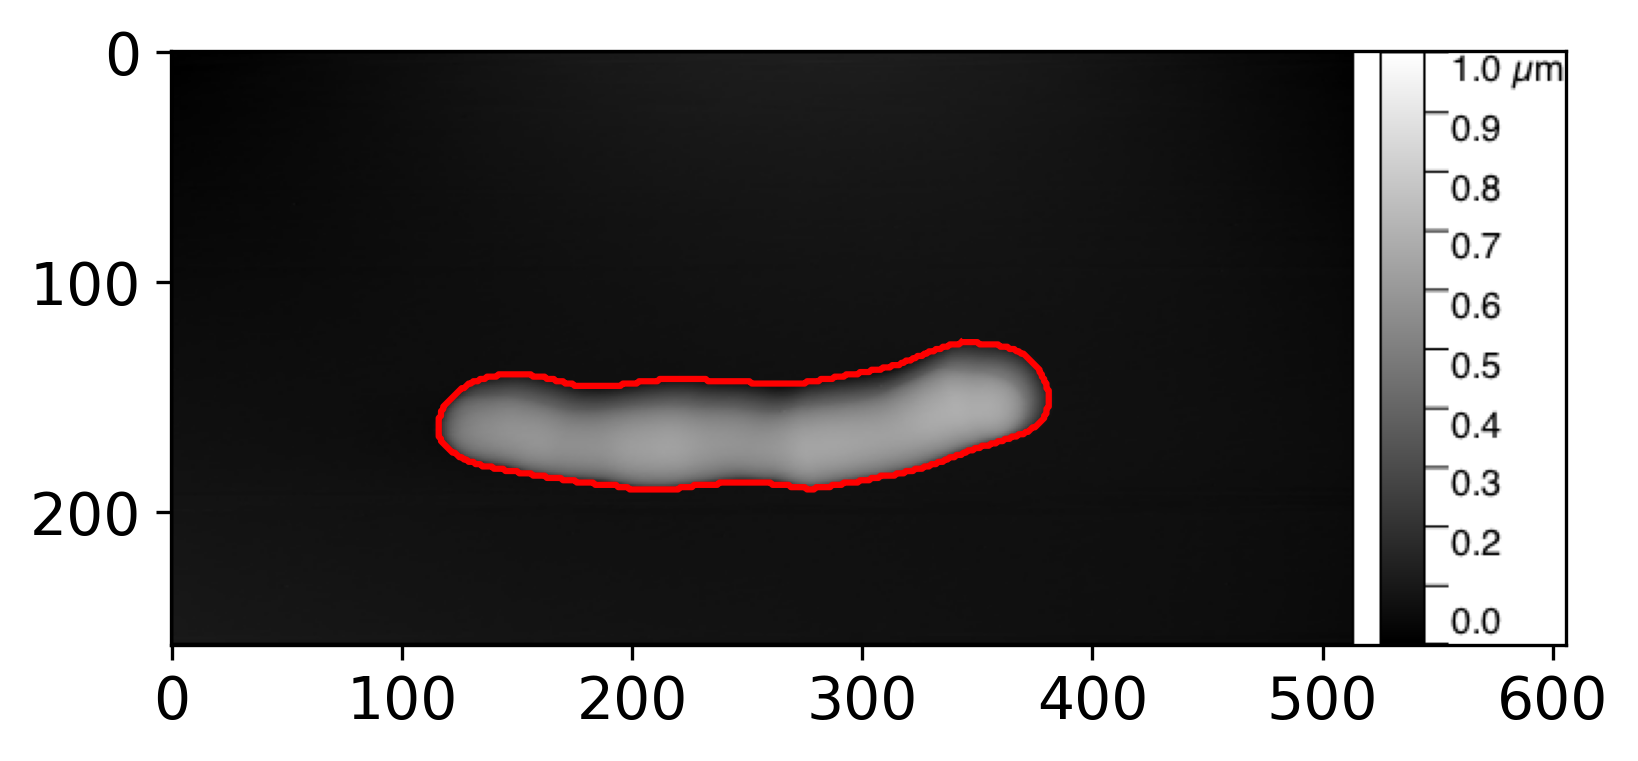

In [4]:
# plotting the original image
plt.imshow(height_img_list[0])
# plotting the outlines. 
for o in outl_temp[0]:
    plt.plot(o[:,0], o[:,1], color='r')

In [5]:
# The image dictionary contains the complete images for all of the image types. 
img_dict = {
    "Height": height_img_list,
    }

# The metadata dictionary will hold all of the data we want to save into our final table.
metadata_dict = {}

# The individual cell dictionary will save information for each individual cell such as the outline, skeleton, cropped image, etc. 
ind_cell_dict = {}

# The structural dictionary will hold information on the timepoint of each image, the cell IDs for each cell in each image,
# and the outlines and bounding boxes for each cell in each image.
structural_dict = {
    "Time": time_list
    }

### 3.2.2 Create bounding boxes for each cell outline

A bounding box is the smallest possible rectangle that can contain all of the points within a shape. Creating bounding boxes for each of our cell outlines will allow for the quick computation of the center points (centroids) of each cell which is necessary for cell tracking. Furthermore, detecting bounding box intersections can be used as a quick way to determine if two cells might be touching each other which allows for an optimization of our cell overlap measuring algorithm. 

In [6]:
# Initialize a list of boxes
boxes_temp = []
box_img = copy.deepcopy(height_img_list)

# Fill lists with the coordinates of bounding boxes for each cell outline.
for outl, img in zip(outl_temp, box_img):
    boxes = tools.get_boxes(outl)
    boxes_temp.append(boxes)
    for box in boxes:
        (startX, startY, endX, endY) = box.astype("int")
        cv2.drawContours(img, [box.astype("int")], -1, (0, 255, 0), 2)

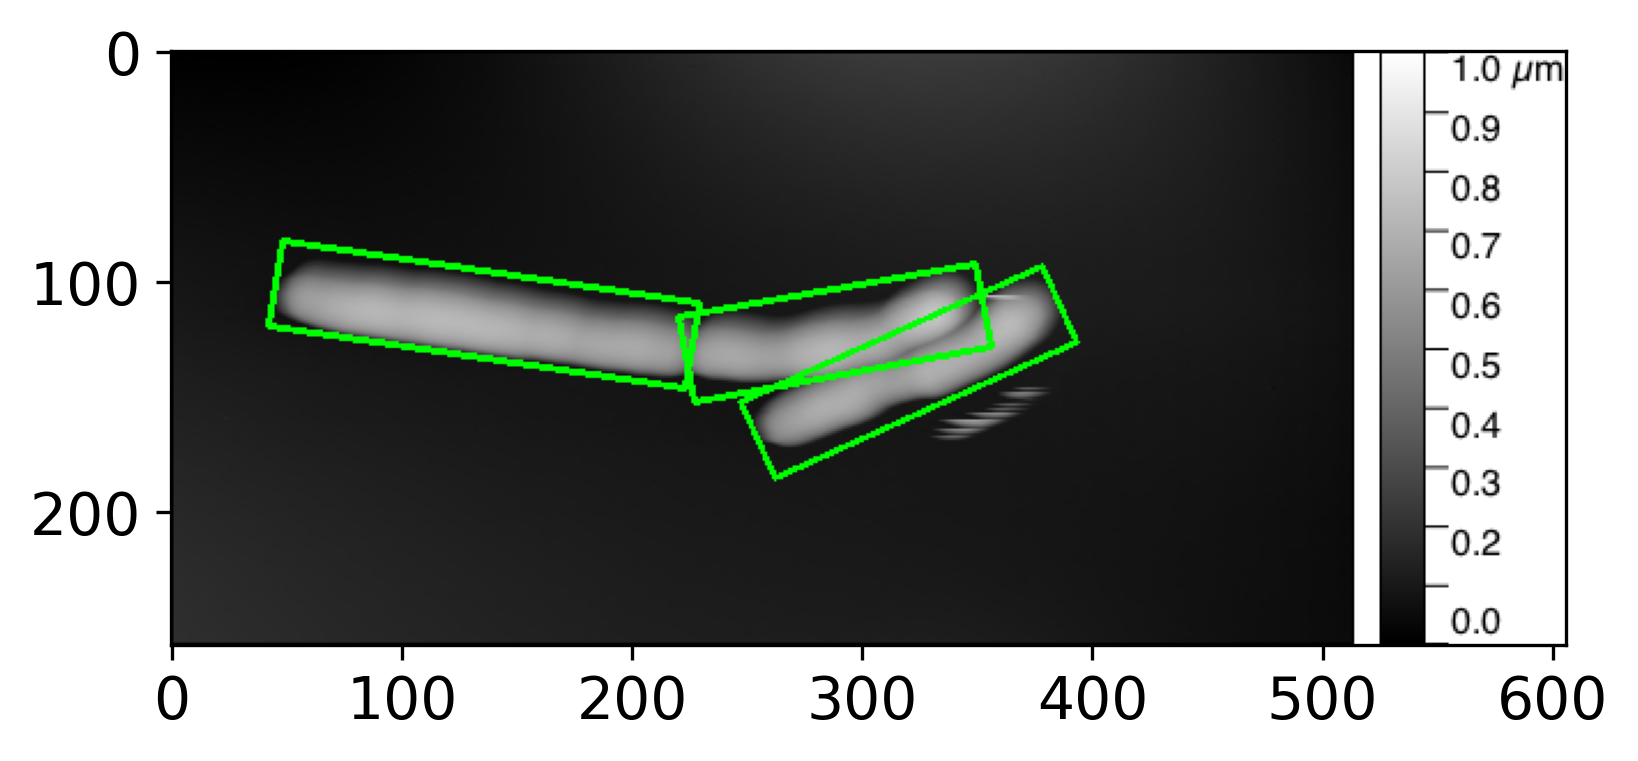

In [7]:
# create an example to illustrate the bounding boxes. 
plt.imshow(box_img[31])

### 3.2.3 Cell Tracking
The object tracking algorithm implemented in this protocol takes an initial set of cell bounding boxes and then assigns a unique ID to each cell. It then tracks the cells as they move through time in subsequent images while maintaining the same assignment of IDs. This algorithm can then output the IDs from each image as a list along with a list of associated cell outlines. By estimating our parameters of interest using these new ID-associated outline lists, we can effectively keep track of which parameters belong to the which cells across multiple images/timepoints. 

The cell tracking algorithm used in this analysis can be summarized as follows:
1. Use the bounding box coordinates to compute the centroids for each cell.
2. Compute the centroids for the next image and calculate the euclidean distance between the old centroids and the new centroids. 
3. Update the coordinates of the old centroids as being equal to the closest new centroids. 
4. If a new centroid is not matched to a pre-existing centroid, register it as a new cell. 
5. If an old centroid cannot be matched to any new centroids, deregister that cell. 

In [8]:
# initialize our centroid tracker and frame dimensions
ct = tools.CentroidTracker()
(H, W) = (None, None)

# Initialize a new set of lists that will contain lists of IDs, outlines, and centers for each image file. 
IDs_list = []
outl_list = []
boxes_list = []
centers_list = []

# loop over the outlines and boxes for each file.
for boxes, img, outls in zip(boxes_temp, box_img, outl_temp):
    # update our centroid tracker using the computed set of bounding box rectangles
    objects = ct.update(boxes, outls)
    # Initialize a new set of lists
    IDs = []
    outl_new = []
    boxes_new = []
    centers = []
    # loop over the tracked objects
    for (objectID, info) in objects.items():
        # draw both the ID of the object and the centroid of the
        # object on the output frame
        text = "ID {}".format(objectID)
        cv2.putText(img, text, (info[1][0] - 10, info[1][1] - 10),
            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
        cv2.circle(img, (info[1][0], info[1][1]), 4, (0, 255, 0), -1)
        # append the object ID and its associated outline and center to the lists. 
        IDs.append(objectID)
        outl_new.append(info[2])
        centers.append(info[1])
        boxes_new.append(info[0])
    boxes_list.append(boxes_new)
    IDs_list.append(IDs)
    outl_list.append(outl_new)
    centers_list.append(centers)

In [9]:
# Add our new lists to the proper dictionaries. 
structural_dict["IDs"] = IDs_list
structural_dict["outlines"] = outl_list
structural_dict["bounding_boxes"] = boxes_list

metadata_dict["centroids"] = centers_list

# Destroy the temporary lists to get some more space. 
boxes_temp.clear()
outl_temp.clear()

The below code outputs a series of images which illustrate the cell tracking process. One can observe new cell IDs being assigned as cell division events occur. These new IDs are then subsequently tracked over multiple images. 

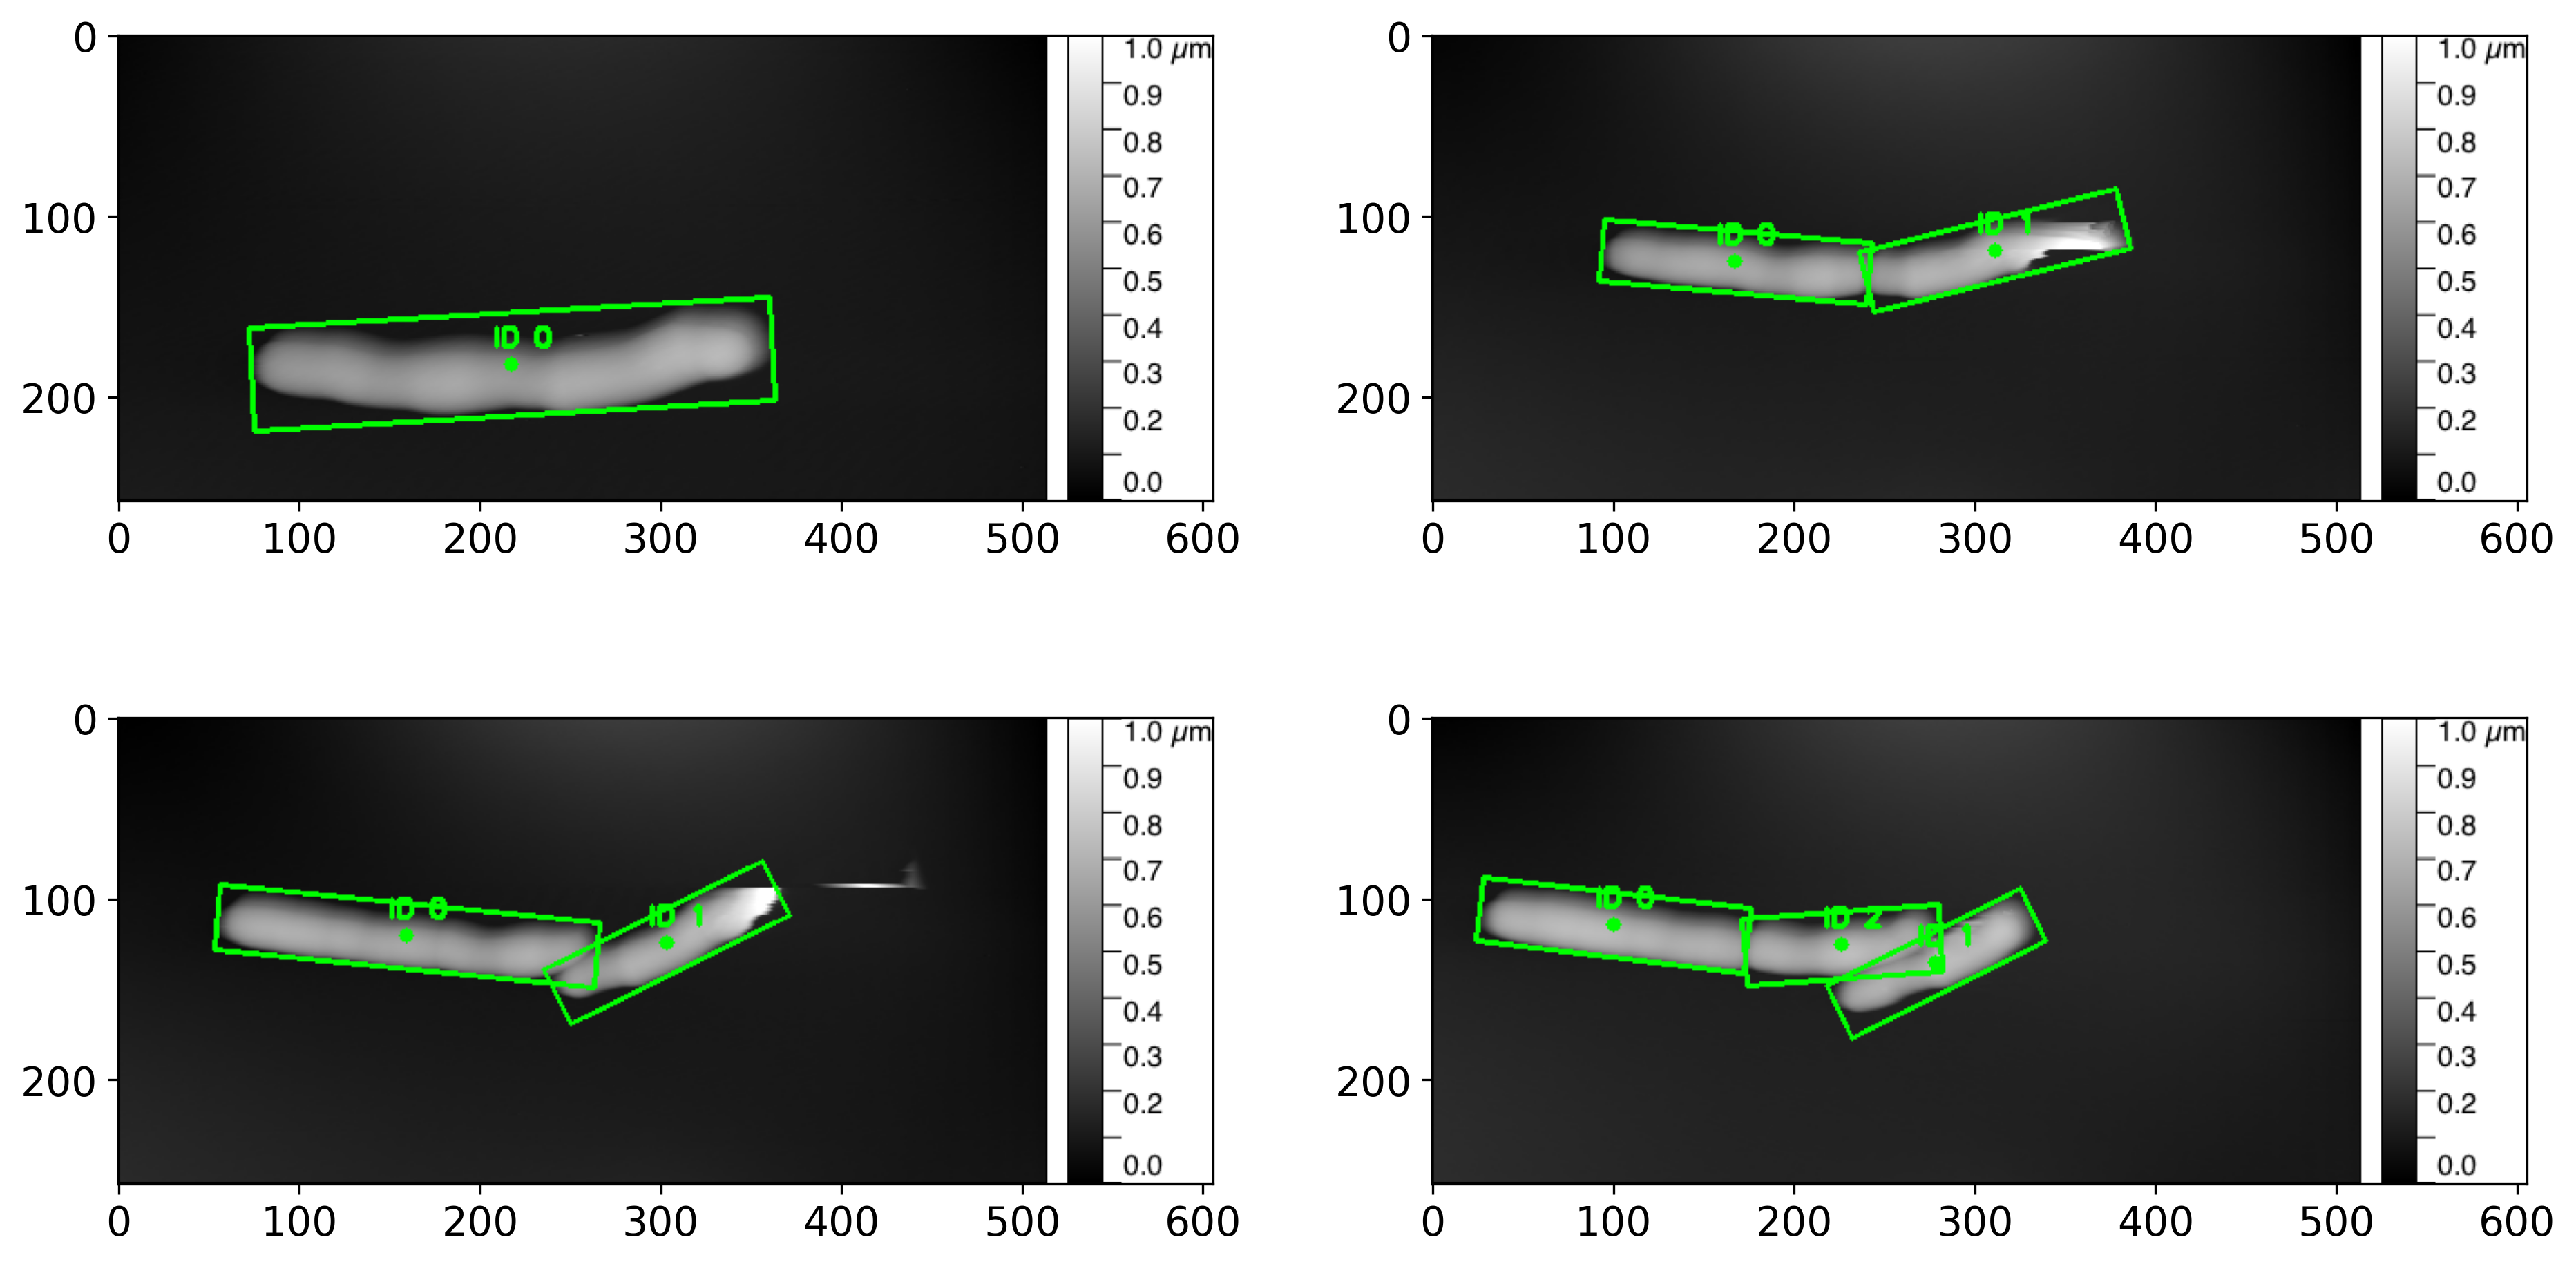

In [10]:
# Plot the outputs to see how the cells are tracked over time.
fig, ax = plt.subplots(2,2, figsize = (15,8))
ax[0][0].imshow(box_img[2])
ax[0][1].imshow(box_img[14])
ax[1][0].imshow(box_img[20])
ax[1][1].imshow(box_img[26])

### 3.2.4 Determining the perimeter, area, and overlap of cells
The first piece of metadata that will be collected for each cell within each image is the perimeter size, area, and degree of cell overlap. Perimeter and area can be quickly and easily calculated using the outlines outputted by Cellpose. The degree to which each cell overlaps with other cells can be calculated using the following algorithm:
1. Take the bounding box for one of the cells in the image. 
2. Detect if the bounding box from that cell intersects with any of the bounding boxes from the other cell in the image. 
3. If the bounding boxes do intercept, compare the distance between the pixels from the outlines. If the distance between the pixels is one, then add 1 pixel to the amount of overlap for that cell. 
4. Repeat steps 1-3 for every cell in every image. 


In [11]:
metadata_dict["Perimeter"], metadata_dict["Area"] = tools.peri_area(outl_list)

metadata_dict["Overlap"] = tools.get_overlap(outl_list, boxes_list)

### 3.2.5 Save individual cells and their outlines
In this protocol, skeletonization is completed using the MATLAB function bwmorph. As such, it is necessary to save each individual cell from each image as its own isolated image and mask so that these masks can be used as inputs for the MATLAB code. 

In [12]:
ind_cell_dict["Height"], ind_cell_dict["Mask"] = tools.extract_ind_cells(IDs_list, outl_list, img_dict["Height"])

### 3.2.6 Skeletonization of individual cells

The skeletonization algorithm can be run using the "prune2" algorithm in tools.py. The MATLAB code will automatically perform skeletonization on all of the individual cell masks contained within each timepoint folder.

The algorithm takes the individual cell masks as inputs. It then converts the masks into binary images (Figure d), and performs skeletonization using the bwmorph function from Matlab's image Processing Toolbox. This creates the initial medial axis (Figure e). The resulting skeleton often splits into two branches at either end of the cell. Our algorithm adjusts for this by finding the average point between the tips and then extending the medial axis to that average point (figure f). The output of the code is a matrix with two columns that represent the x and y coordinates of the medial axis.

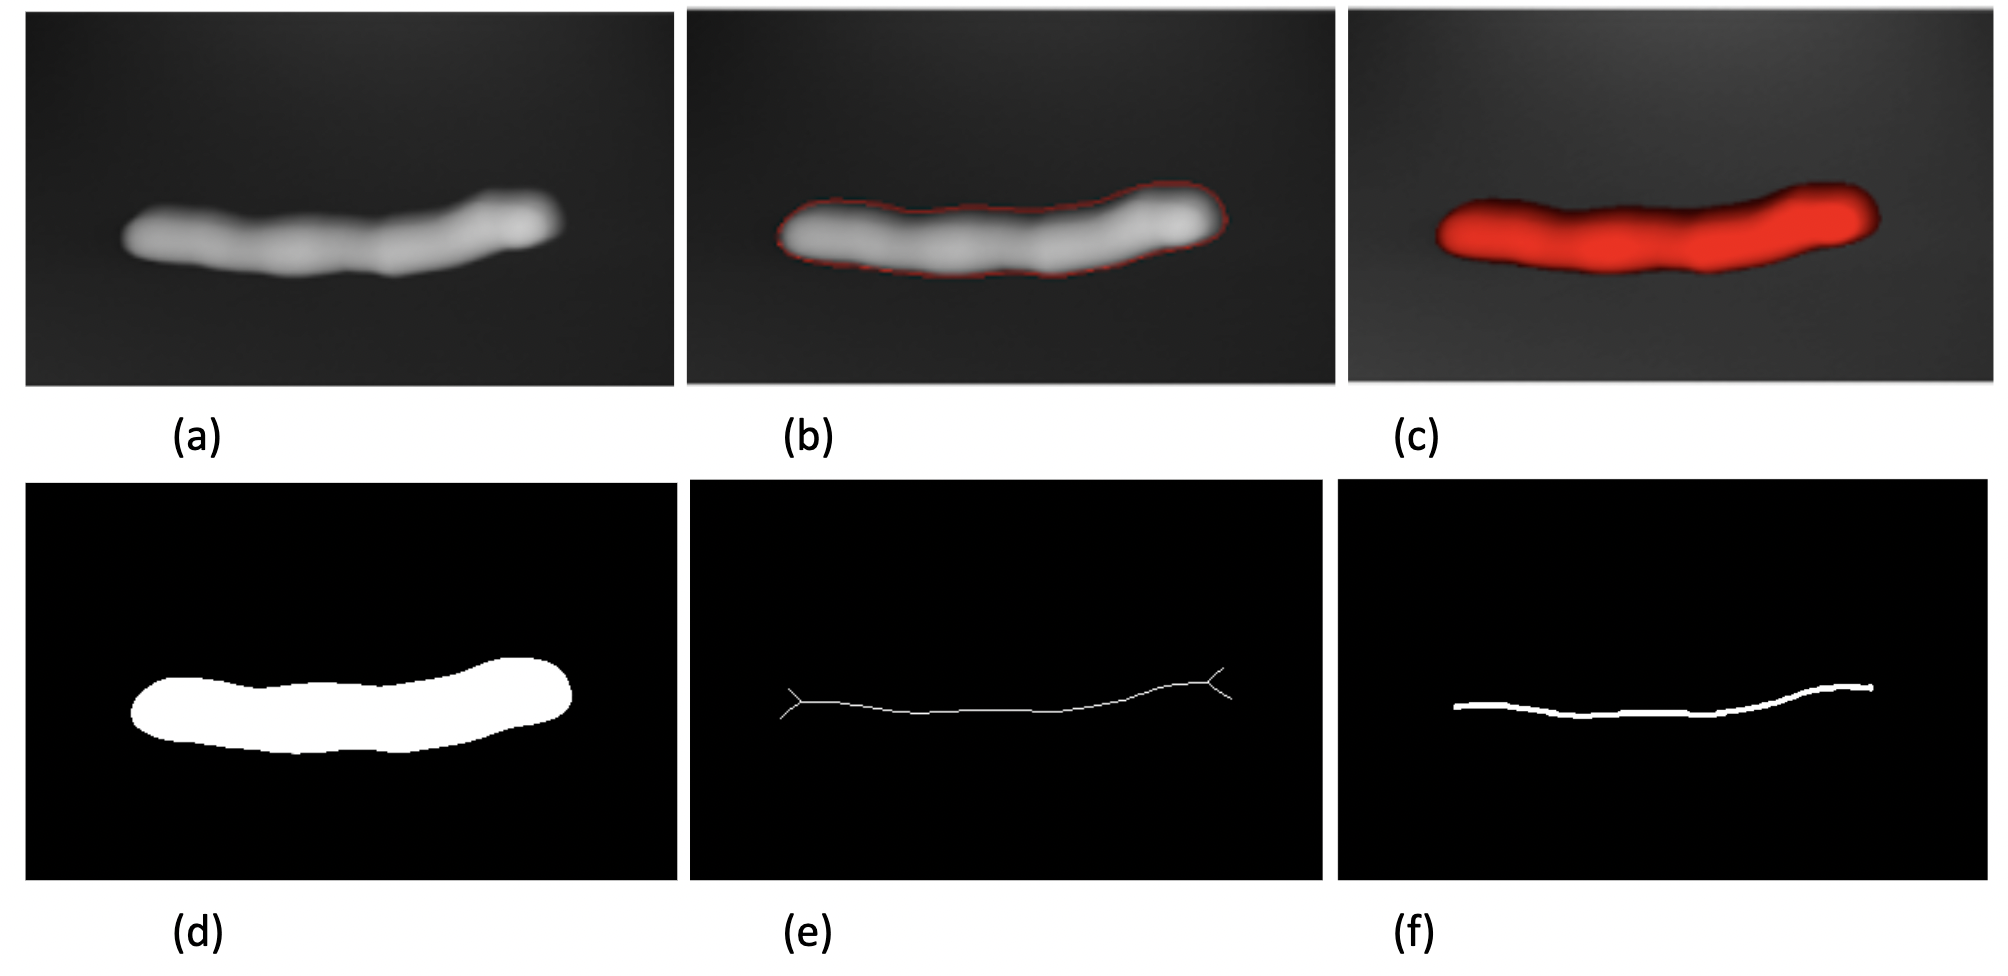

a) image of the cell, b) segmented image of the cells, c) mask of the cell, d) binarized   image of the cell, e) initial skeleton, f) final skeleton


In [44]:
#list of skeletons (before and after branch pruning) with associated timepoints
unpruned_skel_list=[]
skel_list = []
#list of masks with skeletons overlayed in black
over_list=[]
#lists of poles, lengths, and centroids
pole_list = []
length_list = []
centroid_list = []
for time, mask_set in zip(structural_dict["Time"], ind_cell_dict["Mask"]):
    unpruned_skel_set = []
    skel_set = []
    over_set = []
    length_set = []
    pole_set = []
    centroid_set = []
    #create skeletons; save masks, skeletons, and masks with skeletons as lists, save skeletons and skeletons with masks as images
    for mask in mask_set:
        new_mask=mask[:,:,0]>0
        unpruned_skel = tools.padskel(mask)
        outline = utils.masks_to_outlines(new_mask)
        long = np.shape(unpruned_skel)[0]<np.shape(unpruned_skel)[1]
        poles,centroid = tools.explore_poles(outline,long)
        skel,length,pts,s = tools.prune2(unpruned_skel,outline,new_mask,poles)
        over = invert(skel+invert(new_mask)) #the mask overlayed on the skeleton (boolean array)
        pole_set.append(poles)
        unpruned_skel_set.append(unpruned_skel)
        skel_set.append(skel)
        over_set.append(over)
        length_set.append(length)
    pole_list.append(pole_set)
    unpruned_skel_list.append(unpruned_skel_set)
    skel_list.append(skel_set)
    over_list.append(over_set)
    length_list.append(length_set)

In [45]:
# Adding to dictionaries. 
ind_cell_dict["Skeleton"], ind_cell_dict["Skel + Mask"], ind_cell_dict["Unpruned"] = skel_list, over_list, unpruned_skel_list
metadata_dict["Length"] = length_list
metadata_dict["Poles"] = pole_list

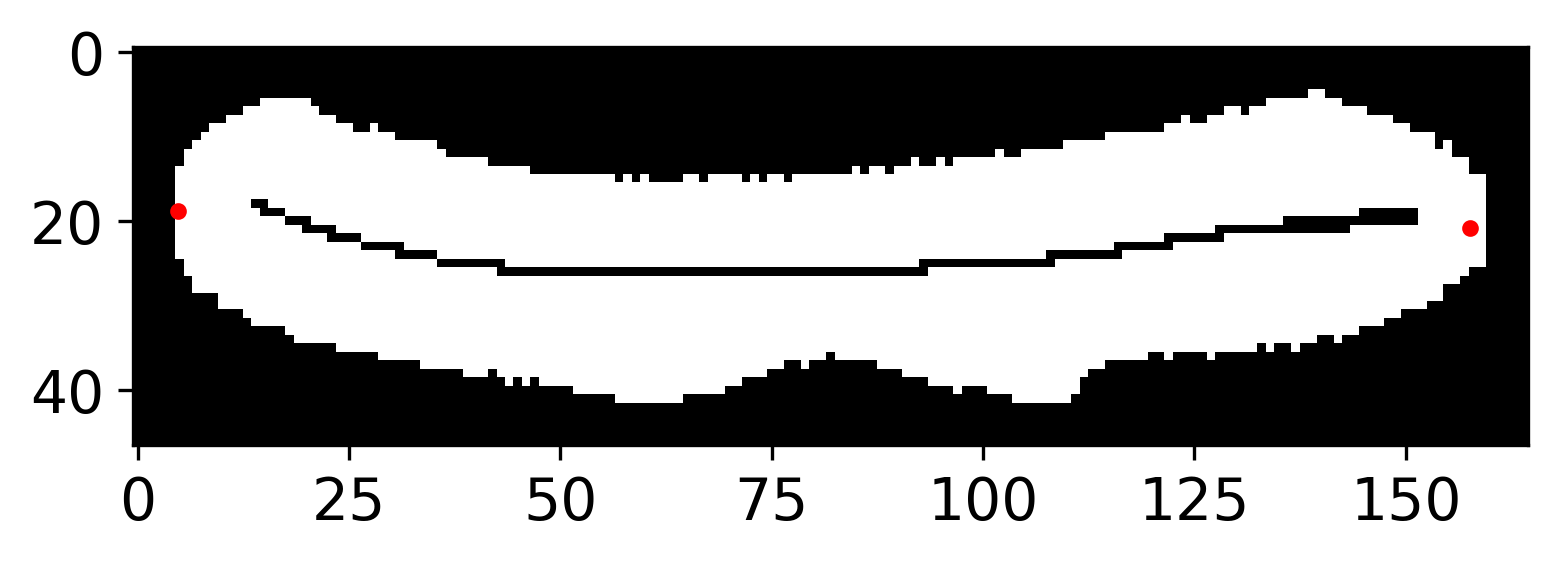

In [63]:
[start_pole,end_pole]=metadata_dict["Poles"][35][2]
skel = ind_cell_dict['Skel + Mask'][35][2]
plt.imshow(skel,cmap=plt.cm.gray)
plt.plot(start_pole[0],start_pole[1],'r.')
plt.plot(end_pole[0],end_pole[1],'r.')

### 3.2.7 Measuring the length of the skeletons
The length of the cell skeletons can be quickly measured by converting our output skeletons into filfinder skeletons using the filfinder python package(Koch & Rosolowsky, 2015). This package automatically calculates the continuous length of the skeleton. 

In [28]:
%%capture 
length_list

### 3.2.8 Using RadFil to build and analyze the radial profile

RadFil is a python package that was originally designed to measure the radial profiles of interstellar filaments, but can be readily applied to other structures such as cells (Zucker et al., 2018). Radfil was chosen for this analyses because it grants the user full control over the parameters used to build and fit the radial profiles and because of the convenient way it packages the output data.

RadFil takes the cell image, mask, and skeleton from each isolated cell as input. It then performs spline interpolation by fitting a b-spline to the original skeleton which creates a smoothed, continuous version of the original skeleton. RadFil then creates a series of cuts at even points along the skeleton which are perpendicular to the tangent of the skeleton at each cut point. These perpendicular cuts extend to the edge of the cell mask, and can therefore be used to compute the radius or diameter of the cell at every point along the skeleton. RadFil also saves the pixel intensities along the smoothed skeleton, which can be used to calculate the height along the skeleton which is also known as the ridgeline. 

In [15]:
h_conv = 3.9215686274509802
s_conv = 392.15686274509802
p_conv = 1
# There is currently insufficient information supplied with the image files to convert the PFE pixel intensities to useful units. 

In [16]:
%%capture

# For each image file we are analyzing, we are going to use RadFil to create a RadFil object and then extract the distance
# And pixel intensity profiles from each cell. 
metadata_dict["Intensity Profile"], metadata_dict["Ridgeline"], metadata_dict["Distance Profile"], metadata_dict["Width"] = tools.apply_radfil(ind_cell_dict["Height"],
                                                                                                                                         ind_cell_dict["Mask"], 
                                                                                                                                         ind_cell_dict["Skeleton"],
                                                                                                                                        conv = 3.9215686274509802)

/home/WereSalmon/miniconda3/envs/cellpose/lib/python3.8/site-packages/radfil/radfil_class.py:105: UserWarning: `header` and `distance` will not be used; all calculations in pixel units.
  warnings.warn("`header` and `distance` will not be used; all calculations in pixel units.")
/home/WereSalmon/miniconda3/envs/cellpose/lib/python3.8/site-packages/radfil/radfil_class.py:156: UserWarning: Calculate in pixel scales.
  warnings.warn("Calculate in pixel scales.")


No binning is applied.


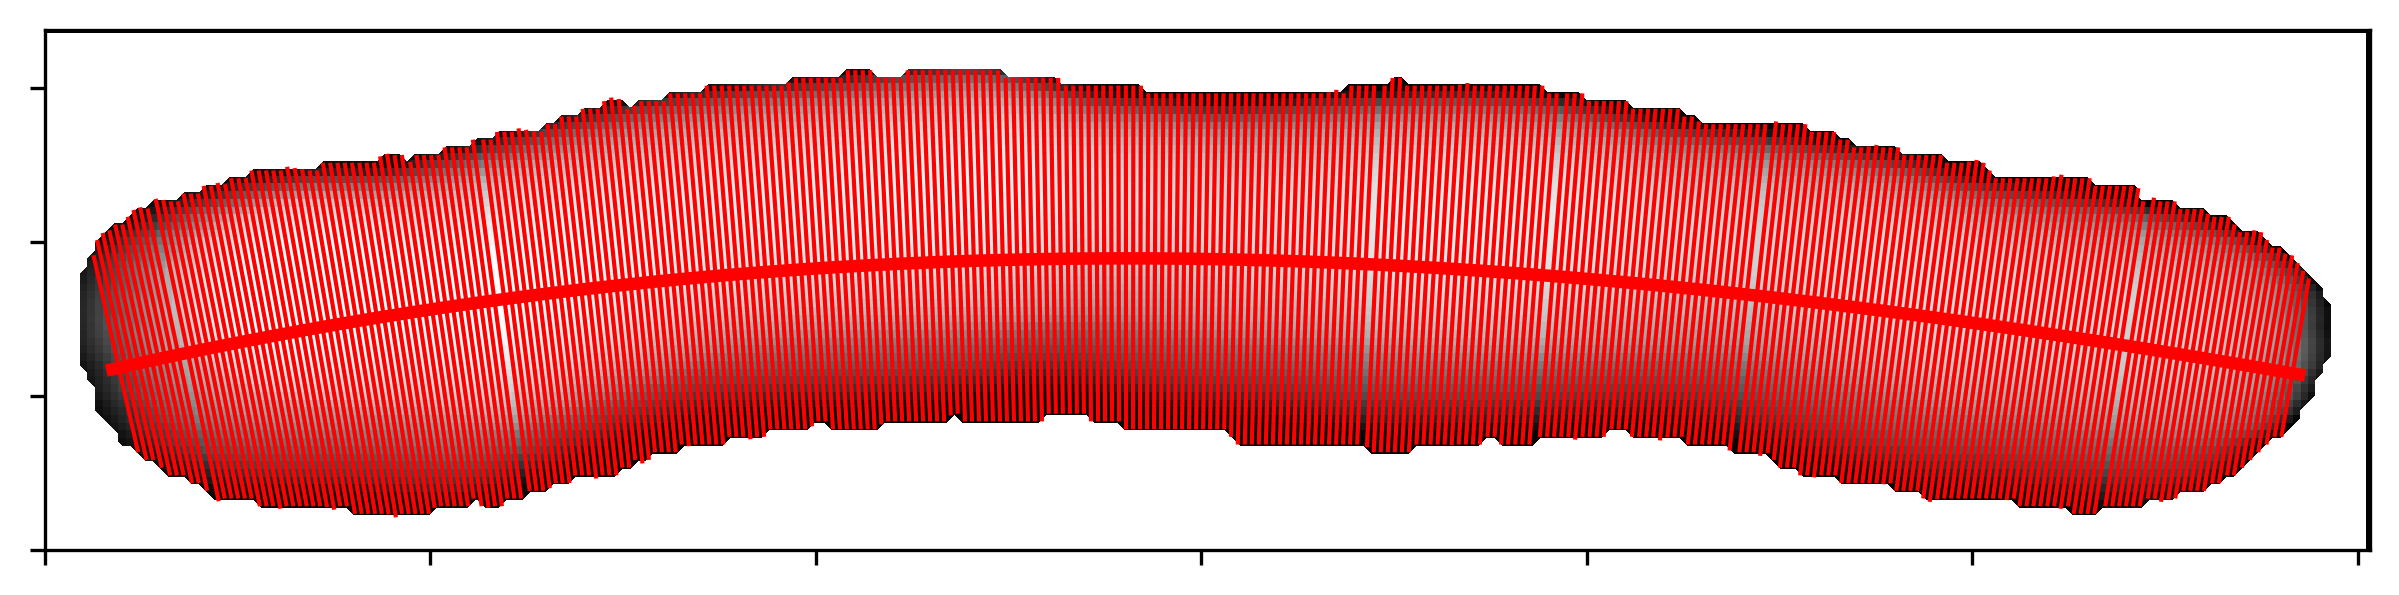

In [17]:
# Load the cell image
fil_image = ind_cell_dict["Height"][3][0][:,:,0]
            
# Load the cell mask and convert to a boolean array. 
fil_mask = ind_cell_dict["Mask"][3][0][:,:,0]>0

# Load the cell skeleton. 
fil_skeleton = ind_cell_dict["Skeleton"][3][0]>0
fil_skeleton[0,:] = False
            
# Use RadFil to create a radial profil object and then append this object to a list.
# We will use the data stored in this object to calculate height and radial profile along the
# medial axis. 
radobj=radfil_class.radfil(fil_image, mask=fil_mask, filspine=fil_skeleton, distance=200)
radobj.build_profile(samp_int=1, shift = False)

An example RadFil output. Cuts made perpendicular to the skeleton extend to the cell boundary and can be used to measure the radius or diameter of the cell along the medial axis. Pixel intensities along the skeleton are also recorded. 

### 3.2.9 Organize everything into metadata tables
Once all of the data has been collected for each individual image and cell, the data needs to be organized into a useful format. The following code loops through every cell ID that was assigned during cell tracking. For each Cell ID, it then loops through all of the data lists we have created and places all of the data for that image/timepoint into a row. If there was no data for a certain timepoint, the row is left empty. The result of this is a table for each cell that shows when that cell appeared/dissapeared along with its perimeter size, area, degree of overlap, center position, radial profile, ridgeline, and skeleton length at each timepoint. 

In [19]:
# Find the last ID which was assigned during the cell tracking.
max_ID = tools.get_max_ID(structural_dict["IDs"])+1

# For each cell that was given an ID, Create a table of metadata. 
for i in range(max_ID):
    df = tools.get_metadata(metadata_dict, structural_dict, i)
    df.to_csv("metadata/05-10-2015/cell_id_" + str(i) + ".csv", index = False)

In [22]:
ex = tools.get_metadata(metadata_dict, structural_dict, 0)
ex.head()

Time   centroids   Perimeter     Area  Overlap      Length  \
0  3301940  [248, 161]  607.119838  11326.5        0  260.463364   
1  3302004  [224, 199]  617.906635  10428.0        0  271.872199   
2  3302013  [217, 182]  653.119838  11826.5        0  283.731831   
3  3302022  [216, 178]  663.705625  12462.0        0  286.762556   
4  3302032  [238, 154]  685.948265  12909.5        0  302.191781   

                                   Intensity Profile  \
0  [[0.0, 0.0, 0.0, 0.0, 0.0, 27.45098039215686, ...   
1  [[0.0, 0.0, 0.0, 0.0, 0.0, 58.8235294117647, 1...   
2  [[0.0, 0.0, 0.0, 0.0, 0.0, 39.2156862745098, 7...   
3  [[0.0, 0.0, 0.0, 0.0, 0.0, 39.2156862745098, 7...   
4  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   

                                           Ridgeline  \
0  [335.71509358597564, 362.27549892658396, 389.5...   
1  [415.60584750477886, 452.6118846149994, 473.55...   
2  [402.51769213781336, 429.3923670038673, 449.59...   
3  [334.6318685398305, 377.6920666502742, 408.407...   
4  [226.8189727956013, 255.28979339606613, 281.77...   

                                    Distance Profile  \
0  [[-22.673518831909153, -21.65688983660271, -20...   
1  [[-18.827996655829647, -18.319097679372888, -1...   
2  [[-21.955806158302146, -20.938633177776072, -1...   
3  [[-23.01810513948396, -22.296381461067277, -21...   
4  [[-41.833599193276335, -40.82252618022829, -39...   

                                               Width  
0  [21.216569909529447, 22.362329957814655, 25.40...  
1  [20.35595905827011, 21.43834771326888, 22.6367...  
2  [23.004277879433207, 24.408283402219705, 25.42...  
3  [20.30176780995835, 21.31461850393491, 23.3421...  
4  [24.265752313153122, 26.288506470345805, 28.31...

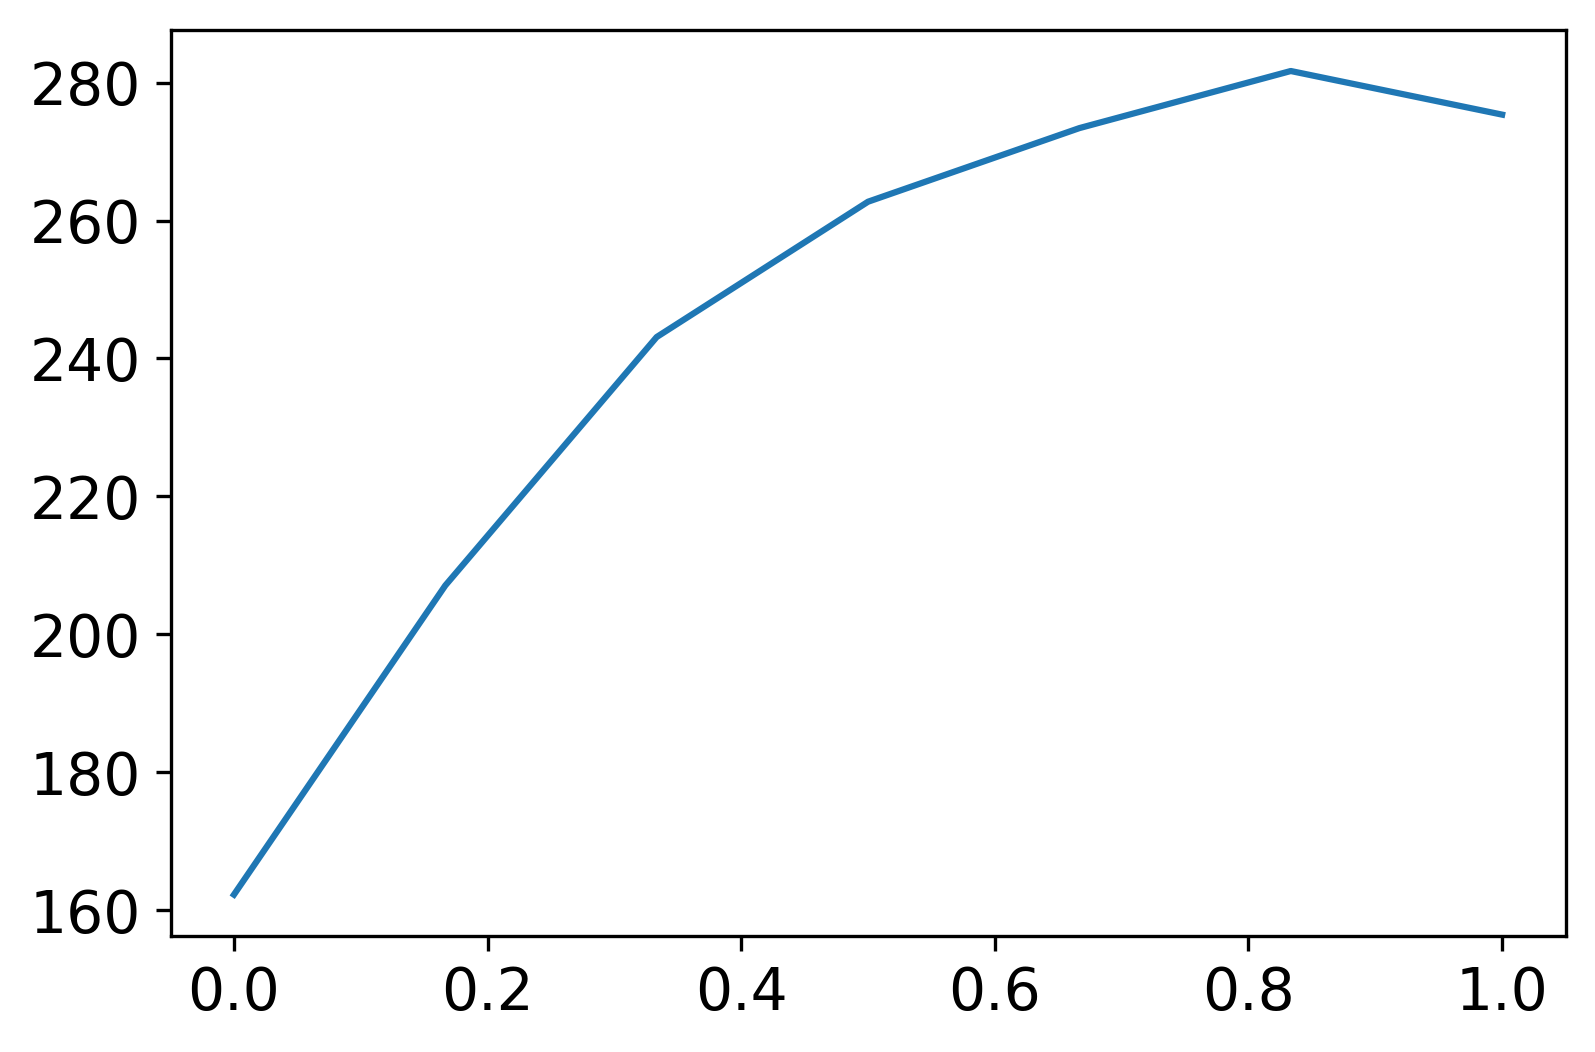

In [77]:
profile = metadata_dict['Ridgeline'][12][1]
s = np.linspace(0,1,len(profile))
plt.plot(s,profile)

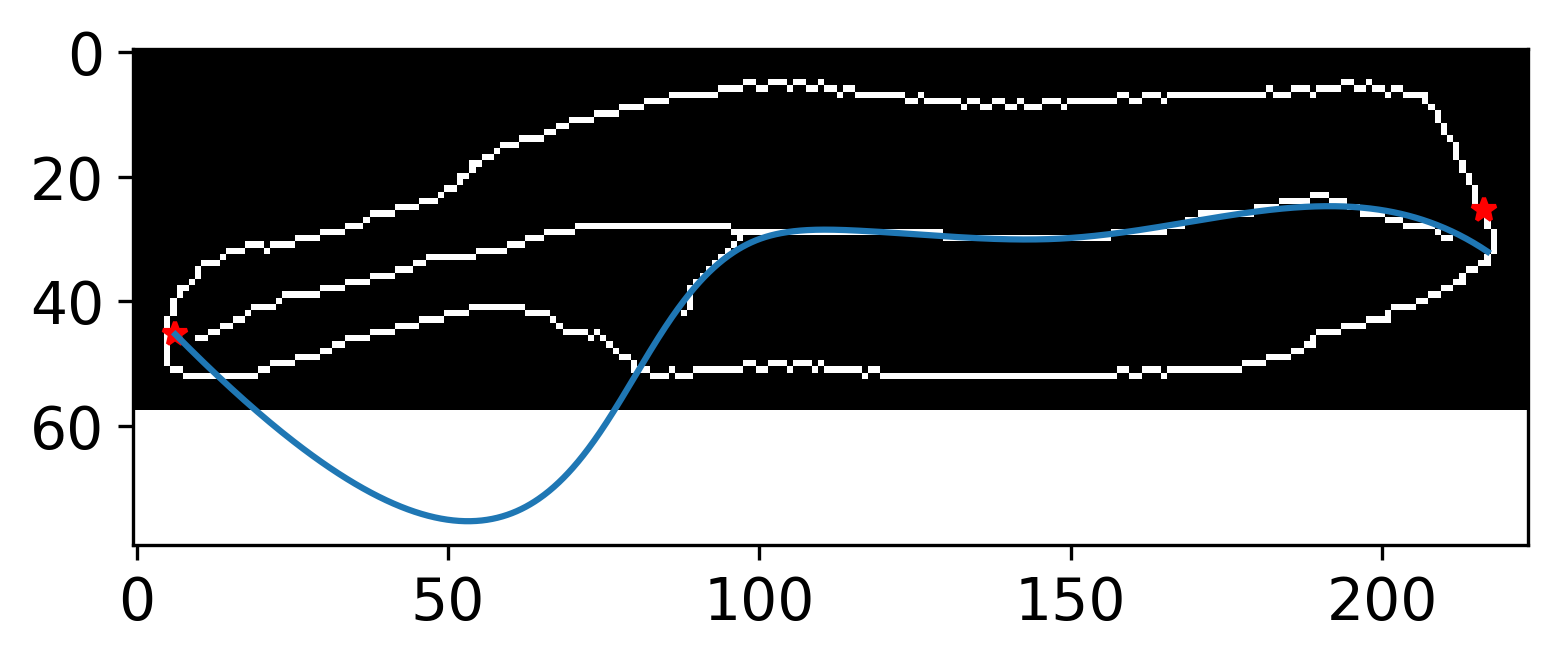

In [107]:
mask = ind_cell_dict['Mask'][12][1][:,:,0]>0
outline = utils.masks_to_outlines(mask)
poles,centroid=tools.explore_poles(outline,True)
[pole1,pole2] = poles
unpruned_skel = skeletonize(mask)
skel,length,[x,y],s=tools.prune2(unpruned_skel,outline,mask,poles)
plt.imshow(unpruned_skel+outline,cmap=plt.cm.gray)
plt.plot(pole1[0],pole1[1],'r*')
plt.plot(pole2[0],pole2[1],'r*')
plt.plot(x,y)

## 4 Results

### 4.1 Height along the ridgeline

In order to demonstrate the effectiveness of this automation method, we replicated figure 1a) from Eskandarian et al. 2017 using the data collected by our protocol.

The first step in generating these plot is to use our get_metadata function to get the data from cell zero and cell 2. Cell 2 is a daughter cell that splits off of cell 1.

In [25]:
# Get metadata for cell 0
ex = tools.get_metadata(metadata_dict, structural_dict, 0)

# Get metadata for cell 2
ex2 = tools.get_metadata(metadata_dict, structural_dict, 2)

We then need to create a series of offsets in order to properly align the ridgelines onto the plot. 

In [49]:
# This list of NA's is used to move the second cell into place so that its end aligns with the wave trough
na_list = []
for i in range(135):
    na_list.append(np.nan)

# These minimums are used to calculate offsets which align all of the first cells hieght profiles 
# Based on the location of te
minimums = []
for ridge in ex["Ridgeline"]:
    minimums.append(ridge.index(min(ridge)))
offsets = []
for mini in minimums:
    offsets.append(minimums[-1]-mini)

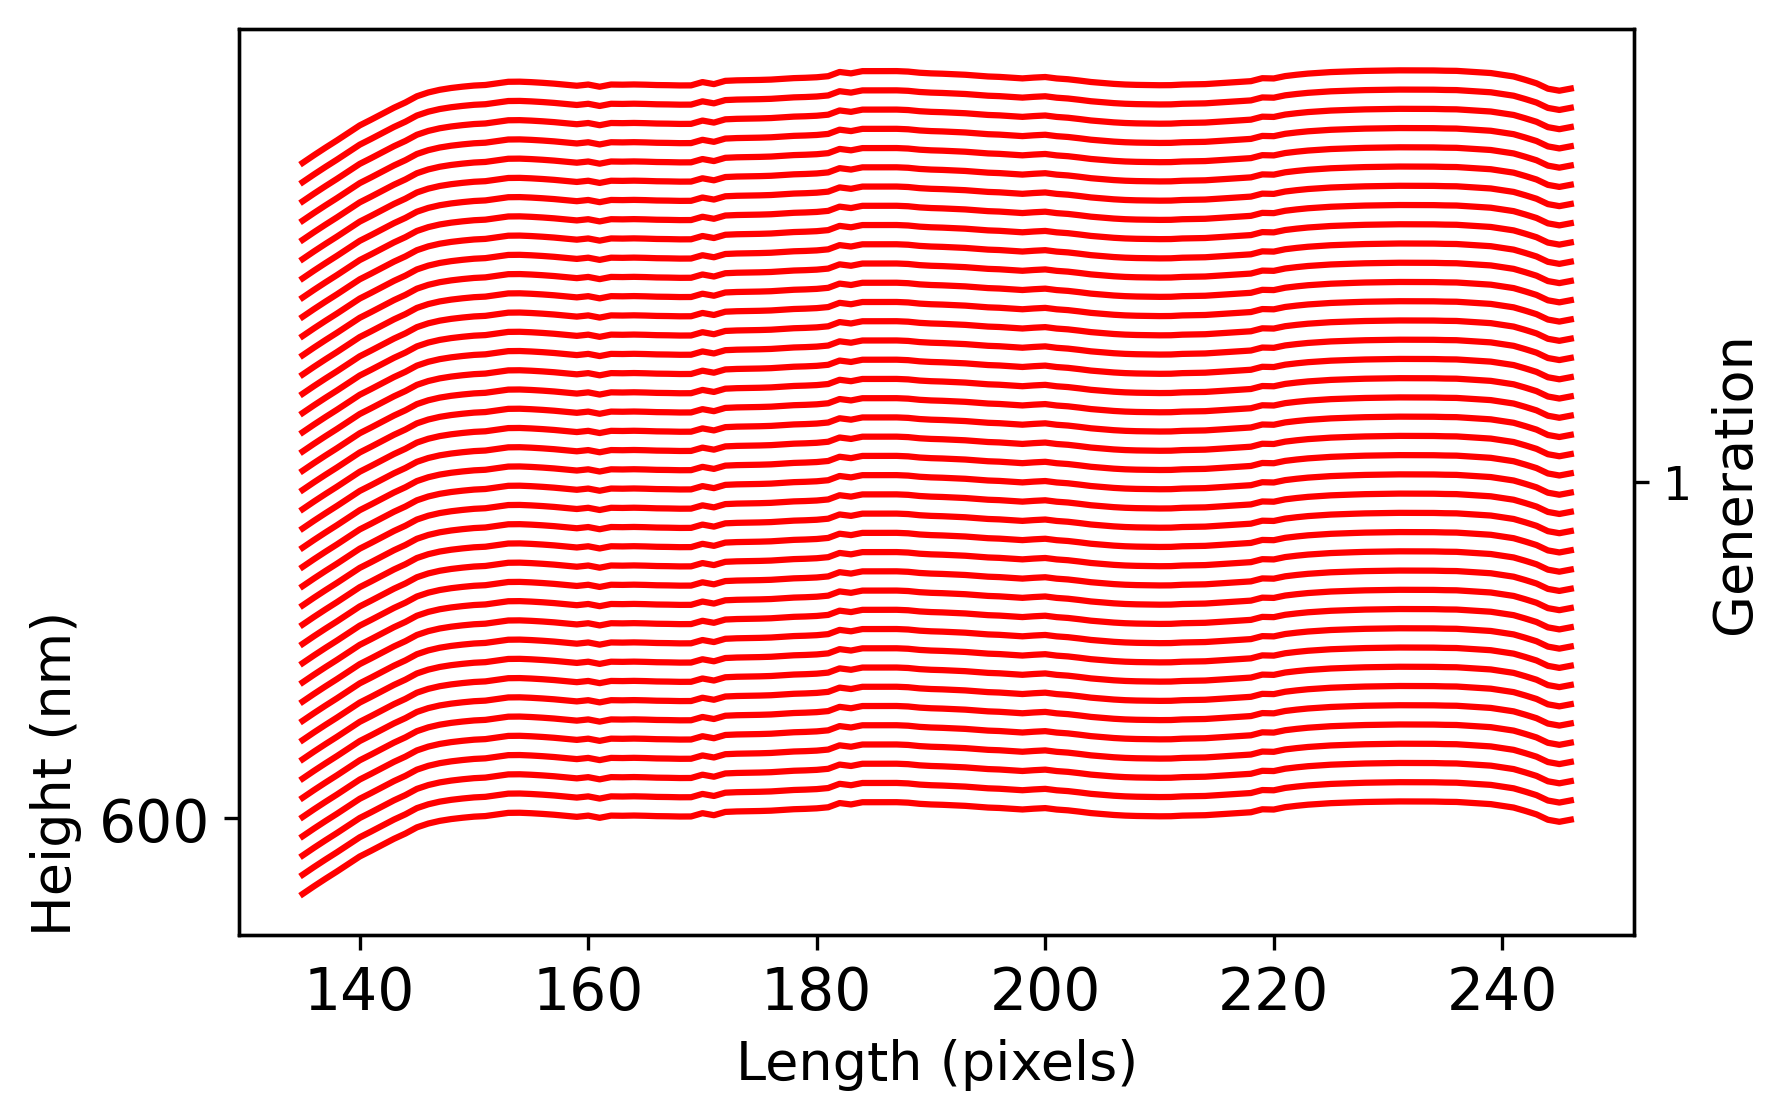

In [55]:
# Create the plot by plotting each ridgeline on top of each other with the proper offsets. 
x = 0
fig,ax = plt.subplots(1,1)
for ridge1, i in zip(ex["Ridgeline"], range(len(ex["Ridgeline"]))):
    if np.isnan(ridge2).any() == True:
        skip = []
        for off in range(offsets[i]):
            skip.append(np.nan)
        ax.plot(np.array(skip+ridge1)+(x), color="k")
        x = x+100
    else:
        ax.plot(np.array(na_list+ridge2)+(x), color = "r")
        x = x+100

# Assign proper labels to all axes. 
ax.set_yticks([600])
ax.set_ylabel("Height (nm)", loc="bottom", fontsize = 13)
ax.set_xlabel("Length (pixels)", fontsize = 13)
ax2 = ax.twinx()
ax2.plot()
ax2.set_yticks([0], rotation=95)
ax2.set_yticklabels(["1"], fontsize = 11)
ax2.set_ylabel("Generation", fontsize = 13)
ax2.tick_params('y', colors='k')

This plot clearly demonstrates the same wave like series of peaks and troughs seen in figure 1a) from Eskandarian et al. Furthermore, we can observe that one of the major wave troughs in the mother cell predicts the location of the site of division. This plot is a clear example of how our automated protocol can replicate results that originally had to be collected by hand. 

### 4.2 Height along a radial slice.

We also decided to look at the height along one of the many radial slices taken by RadFil in order to observe how the height decreases to the left and right of the ridgeline. 

Along the edges of the height profiles there are often several values equal to zero. These are the result of the cell masks being slightly larger than the cell itself. This flaw can be easily adjusted for by removing any value equal to zero. 

In [20]:
# Remove the zero values on the edges of the height profiles. 
heights = ex["Height Profile (nm)"][0][126][ex["Height Profile (nm)"][0][126] != 0]
distances = ex["Distance Profile (nm)"][0][126][ex["Height Profile (nm)"][0][126] != 0]
x_values = np.array(distances) + abs(min(distances))

Text(0.5, 1.0, 'Height Along a Radial Slice')

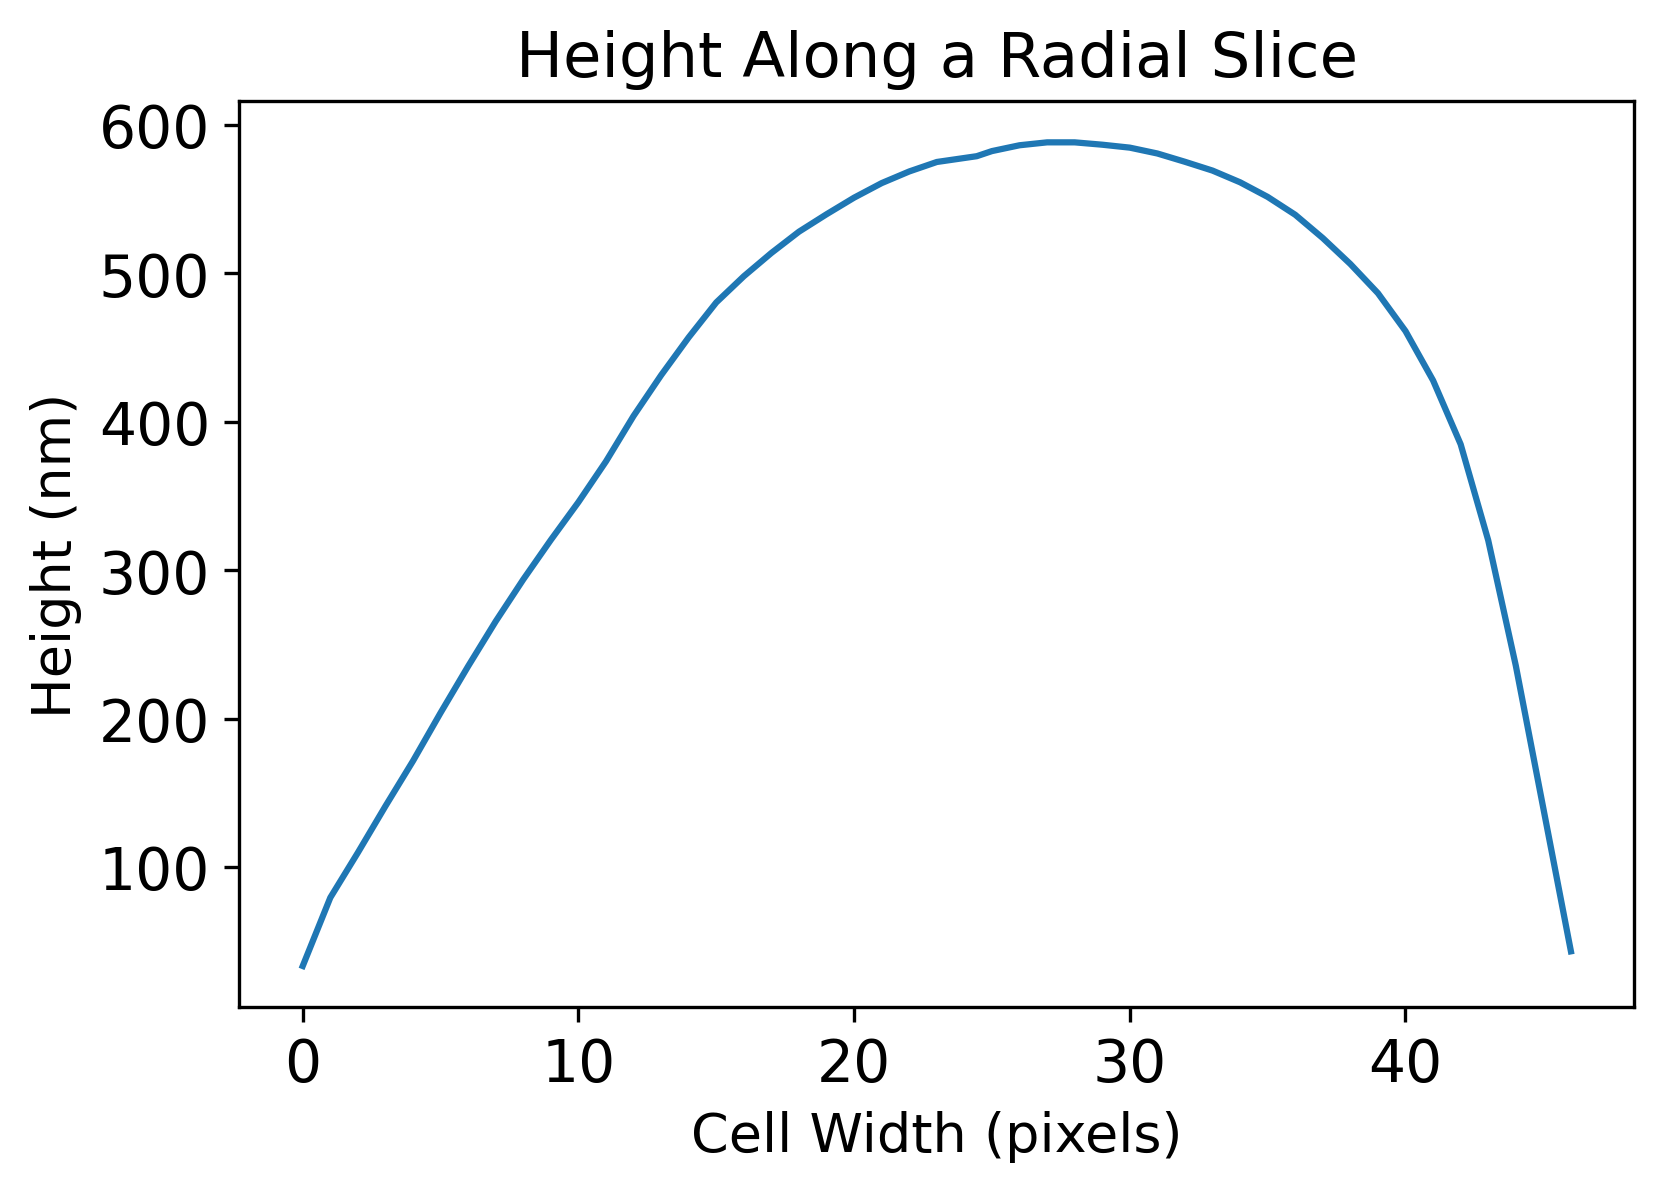

In [21]:
# Plot the height along a radial slice. 
plt.plot(x_values,heights)
plt.ylabel("Height (nm)", fontsize = 13)
plt.xlabel("Cell Width (pixels)", fontsize = 13)
plt.title("Height Along a Radial Slice", fontsize = 15)

This plot appears to show a large difference in curvature to the left and right of the ridgeline of the cell. This difference in curvature is most likely the result of the cantilever used for AFM slowly gliding off one end of the cell rather than sticking to the cells contours. If this difference in curvature can be characterized consistently for each cell, then it may be possible to correct for this AFM gliding in future versions of this protocol to get more accurate cell shapes. 

# 5. Discussion

## 5.1 Limitations

### Cellpose
Although Cellpose has been mostly effective when segmenting our cells, it is occasionally inconsistent when attempting to segment long, irregularly shaped cells or heavily clustered cells. These minor inconsistencies can have major consequences. For example, if a cell somehow fails to be detected and segmented by Cellpose for a single timepoint, then the cell tracking algorithm will interpret that cell as missing and create a new cell ID when it reappears. 

The developers of Cellpose have noted that Cellpose struggles with elongated cell shapes (Cutler et al. 2021). Cellpose attempts to route all of the pixels within a cell to a single cell center via vector flow fields in order to determine which pixels belong to individual cells. This technique works well for any cells which are roughly circular, but in elongated cells defining a singular cell center is extremely difficult. Multiple sinks occur in the vector fields of elongated cells which leads to oversegmentation or a failure to recognize the elongated objects as cells. A potential solution to this problem comes in the form of Omnipose, a new version of Cellpose that is currently in development (Cutler et al. 2021). Omnipose is specifically designed to work with the elongated cell shapes which are common in bacteria. Rather than attempt to direct all of the pixels in a cell to a singular cell center, omnipose uses the distance transform to essentially map all of the pixels in a cell to the nearest point on the cells medial axis. This subverts the original Cellposes problem with defining a singular cell center and has the added benefit of automatically determining the medial axis so that is would not need to be determined seperately. 

Another possible source of error comes from the simple fact that the original training data set contained few images of bacterial cells and most likely contained no AFM images of mycobacteria smegmatis. Therefore, it is possible that Cellpose could be significantly improved by training Cellpose on a subset of our bacterial AFM data in order to create a specialized model for mycobacteria AFM images. This possibility is boosted by the fact that the recently released Cellpose 2.0 boasts greatly improved training pipelines which allow for a specialized model to be trained with only a few hours of human effort (Stringer & Pachitariu, 2022). 

### Frameshifts
In the AFM image dataset, it is not uncommon for the frame of the image to become offset between different timepoints. This offset appears inconsequential to the human eye, but it can cause drastic problems for cell tracking. The tracking algorithm interprets these frameshifts as every cell in the image suddenly moving incredibly quickly which regularly causes to tracking errors. A means of automatically correcting for these frameshifts or a more advanced tracking algoritham that takes into account more information than just the centroid position may be able to address this problem. 

### Skeletonization

The original skeletonization algorithm included an extra step to smooth the boundary of the cells (Xiong et al., 2010). In our dataset, we skipped boundary smoothing for two reasons; one, the skeleton from the original segmented images and the skeleton after boundary smoothing were not significantly different in shape. And two, we don’t need the coordinates of the boundary since our code only outputs a matrix of the medial axis. This can cause loss of information in some images, since the boundary smoothing was suggested to ensure the noise of the images is eliminated.

The algorithm finds the initial skeleton using bwmorph, extracts the skeleton minus the branches generated at the two ends, then for each remaining connected component finds the average (x,y) coordinate and plots it from the root of those branches and connects it to the initially extracted skeleton. Due to the way this skeleton is plotted, this branch pruning method works best on the elongated cells, so for the purposes of our project we are not considering cells with round shapes.

The original algorithm removed short branches at the ends of the cell. However since the example data we are working with did not generally generate short branches, it is not part of the algorithm that we developed. Cells where the skeletonization  generates branches that are rooted close to the center of the cell are also skipped. This can potentially cause an inaccurate skeleton for some exceptional cells because if one of the end branches is shorter than the other one, the average point found could result in the medial line being curved away from the end of the cell.

All of these limitations are functionalities that can be added to our code in future versions. ALthough MATLAB's bwmorph library conveniently plots the initial skeleton and finds the location of branches and endpoints, one possible way to address these limitations is to use python for skeletonization instead.

# 6. Conclusion
In this project, we developed a protocol which automatically segments cells from AFM images and determines their medial axis. We then use the medial axis to collect metadata for each cell such as the length of the cell, the radial profile, and the area and perimeter. We also track changes in individual cell’s measurements over time. Moving forward, the protocol can be developed further to analyze other properties of the cells such as stiffness and to measure additional parameters such as the angle of the of plane division. 

# 7. References

Cutler, K. J., Stringer, C., Wiggins, P. A., & Mougous, J. D. (2021). Omnipose: a high-precision morphology-independent solution for bacterial cell segmentation. bioRxiv.

Koch, E. W., & Rosolowsky, E. W. (2015). Filament identification through mathematical morphology. Monthly Notices of the Royal Astronomical Society, 452(4), 3435-3450.

Stringer, C., & Pachitariu, M. (2022). Cellpose 2.0: how to train your own model. bioRxiv.

Zucker, C., & Chen, H. H. H. (2018). RadFil: A Python Package for Building and Fitting Radial Profiles for Interstellar Filaments. The Astrophysical Journal, 864(2), 152.

Duteil, M. (2018). Collective Behaviour: From Cells to Humans (Doctoral dissertation, Swansea University).

Eskandarian, H. A., Odermatt, P. D., Ven, J. X., Hannebelle, M., Nievergelt, A. P., Dhar, N., ... & Fantner, G. E. (2017). Division site selection linked to inherited cell surface wave troughs in mycobacteria. Nature microbiology, 2(9), 1-6.

Xiong, Y., Kabacoff, C., Franca-Koh, J., Devreotes, P. N., Robinson, D. N., & Iglesias, P. A. (2010). Automated characterization of cell shape changes during amoeboid motility by skeletonization. BMC systems biology, 4(1), 1-18.